In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental import RandomFourierFeatures
#from imgaug import augmenters as iaa

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [2]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    ax.grid()
    
def apply_clahe(img):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance image contrast.

    Parameters:
    - img: NumPy array, input RGB image.

    Returns:
    - Image after applying CLAHE for enhanced contrast.
    """
    
    # Split the RGB image into individual channels
    rgb_planes = cv2.split(img)

    # Create a CLAHE object with a clip limit of 5.0
    clahe = cv2.createCLAHE(clipLimit=5.0)

    # Apply CLAHE to each channel separately
    r = clahe.apply(rgb_planes[0])
    g = clahe.apply(rgb_planes[1])
    b = clahe.apply(rgb_planes[2])

    # Merge the processed channels to obtain the final image
    img = cv2.merge([r, g, b])

    return img

def load_data(data_path, image_size):

    subfolders = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Very Severe NPDR', 'PDR', 'Advanced PDR']

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders:
        img_list=os.listdir(data_path +'/'+ category)
        if("Annotations" in category):
            continue
        
        print('Loading :', len(img_list), 'images of category: ', category)
        for img in img_list:
            # Load an image from this path
            img_path = data_path + '/'+ category + '/'+ img
            # Read the image from the specified path
            img = cv2.imread(img_path)
            # Convert the image from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #pixels = apply_clahe(img)
            img_array=cv2.resize(img, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)        
            img_data_list.append(img_array) 
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels)
    data = np.array(img_data_list)
    
    data_visualization(subfolders, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 187 images of category:  No DR
Loading : 4 images of category:  Mild NPDR
Loading : 80 images of category:  Moderate NPDR
Loading : 176 images of category:  Severe NPDR
Loading : 108 images of category:  Very Severe NPDR
Loading : 88 images of category:  PDR
Loading : 114 images of category:  Advanced PDR

Total number of uploaded data:  757 , with data shape (512, 512, 3)


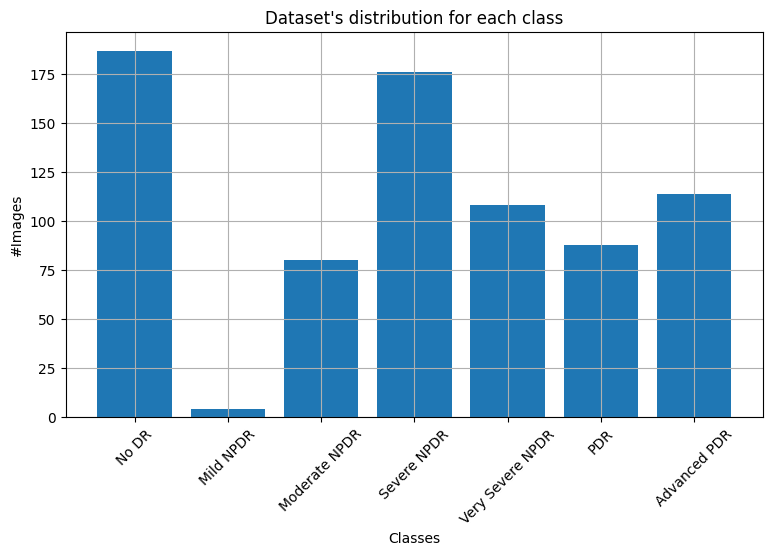

In [3]:
image_size = (512,512,3)
input_shape = image_size
data_path = "/Users/nagurshareefshaik/Documents/MyResearch/EyeResearch-Datasets/Zenodo-DR7"
data, labels = load_data(data_path,image_size)

In [4]:
# Split the dataset into two subsets (80%-20%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=195, stratify=labels)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (605, 512, 512, 3)
y_train has shape: (605, 7)

X_test has shape: (152, 512, 512, 3)
y_test has shape: (152, 7)

X_train + X_test = 757 samples in total


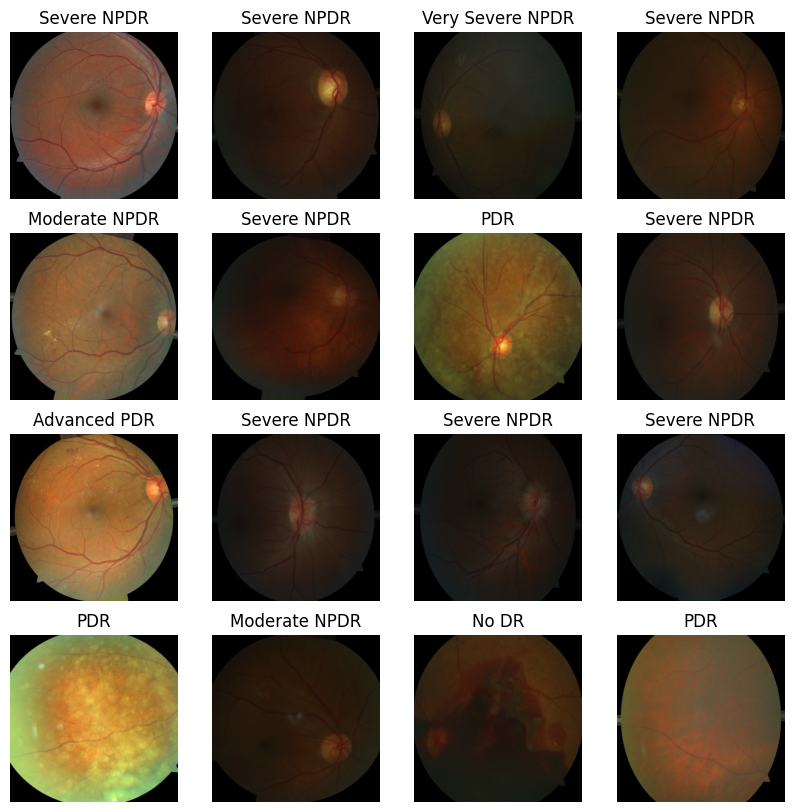

In [5]:
# Map the disease categories
mapping = {0: 'No DR', 1: 'Mild NPDR', 2: 'Moderate NPDR', 3:'Severe NPDR', 4:'Very Severe NPDR', 5: 'PDR', 6:'Advanced PDR'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [6]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextAttention(ip, reduction_ratio=8, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [7]:
from keras.layers import Conv2D, LayerNormalization

class AttentionGate(Layer):
    def __init__(self, filters, **kwargs):
        self.filters = filters
        super(AttentionGate, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable parameters for attention gate
        self.conv_xl = Conv2D(self.filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')
        self.conv_g = Conv2D(self.filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')
        self.psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='linear')
        self.layer_norm = LayerNormalization(axis=-1)
        self.bxg = self.add_weight(name='bxg',
                                  shape=(self.filters,),
                                  initializer='zeros',
                                  trainable=True)
        self.bpsi = self.add_weight(name='bpsi',
                                   shape=(1,),
                                   initializer='zeros',
                                   trainable=True)
        super(AttentionGate, self).build(input_shape)

    def call(self, inputs):
        xl, g = inputs

        # Apply convolutional operations
        xl_conv = self.conv_xl(xl)
        g_conv = self.conv_g(g)

        # Compute additive attention
        att = K.relu(xl_conv + g_conv + self.bxg)
        att = self.layer_norm(att)  # Add LayerNormalization
        att = self.psi(att) + self.bpsi
        att = K.sigmoid(att)

        # Apply attention gate
        x_hat = att * xl

        return x_hat

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [8]:
import tensorflow as tf
from keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads
    
optimizer = GCRMSprop(learning_rate=1e-4)

# Build the model
def build_model(input_shape, num_classes):
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)
    #for layer in base_model.layers:
    #    layer.trainable = False

    fmaps = base_model.output # .get_layer('block5_pool')
    context_fmaps = GlobalContextAttention(fmaps)
    att_fmaps = AttentionGate(fmaps.shape[-1])([fmaps, context_fmaps])
    x = layers.GlobalAveragePooling2D()(att_fmaps)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(input_shape, num_classes=7)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-16 08:44:12.567111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 08:44:12.568631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

print(model.summary())
#plot_model(model, show_shapes=True, to_file='model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 256, 256, 32  864         ['normalization[0][0]']      

In [10]:
EPOCHS = 100
batch_size = 32
model_path = "weights.best.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint] #earlystopping, rlrop

print(f"[INFO] training network for {EPOCHS} epochs...\n")
#hist = model.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_test, y_test),epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...



In [12]:
# Copyright 2020 Samson Woof

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.utils import get_file


def grad_cam(model, img,
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id is None:
            category_id = np.argmax(predictions[0])
        if label_name is not None:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

def grad_cam_plus(model, img,
                  layer_name="block5_conv3", label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap



def preprocess_image(img_path, image_size=(512, 512, 3)):
    """Preprocess the image by reshape and normalization.

    Args:
        img_path: A string.
        target_size: A tuple, reshape to this size.
    Return:
        An image array.
    """
    # Read the image from the specified path
    #img = cv2.imread(img_path)
    # Convert the image from BGR to RGB
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_array=cv2.resize(img, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)        

    img = image.load_img(img_path, target_size=image_size)
    img = image.img_to_array(img)
    
    return img


def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)
    try:
        display(imgwithheat)
    except NameError:
        imgwithheat.show()

    if return_array:
        return superimposed_img

def show_GradCAM(img, heatmap, alpha=0.4, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    # Read the original image
    #img = cv2.imread(img_path)

    # Resize the heatmap to match the original image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply color map to the heatmap
    heatmap = (heatmap * 255).astype("uint8")
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Create superimposed image
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Display the images as subplots
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_colored)
    plt.title('Heatmap')
    plt.axis('off')

    # Superimposed Image
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img_rgb)
    plt.title('Superimposed Image')
    plt.axis('off')

    plt.show()

    if return_array:
        return superimposed_img_rgb


Sample:  1
Actual Label:  Advanced PDR


2024-01-16 08:44:25.195453: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-16 08:44:25.700078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Global Context Attention
(1, 7)
Advanced PDR


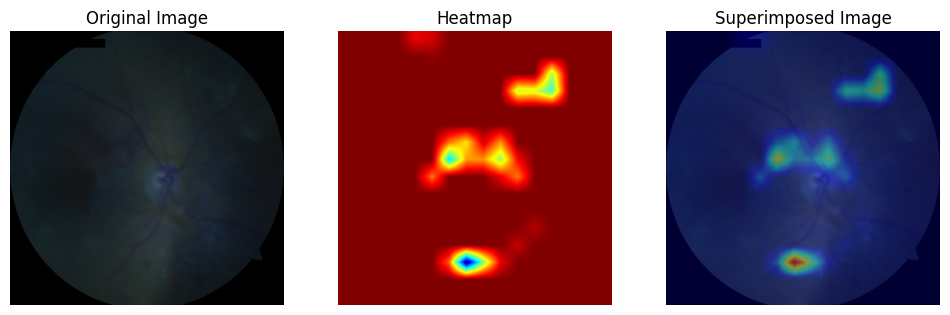

Context Gating Attention
(1, 7)
Advanced PDR


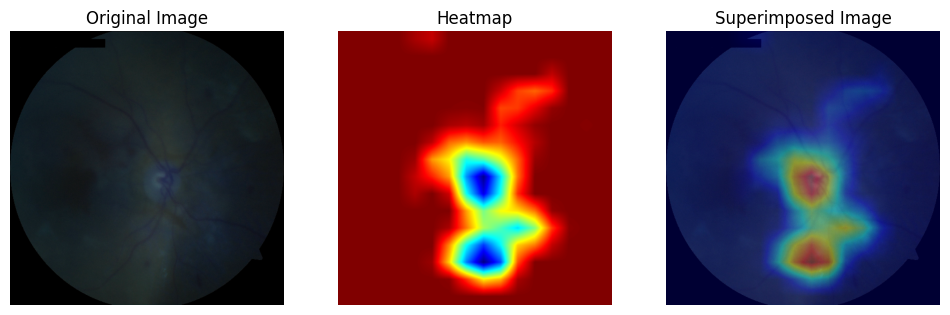

Sample:  2
Actual Label:  Very Severe NPDR
Global Context Attention
(1, 7)
Very Severe NPDR


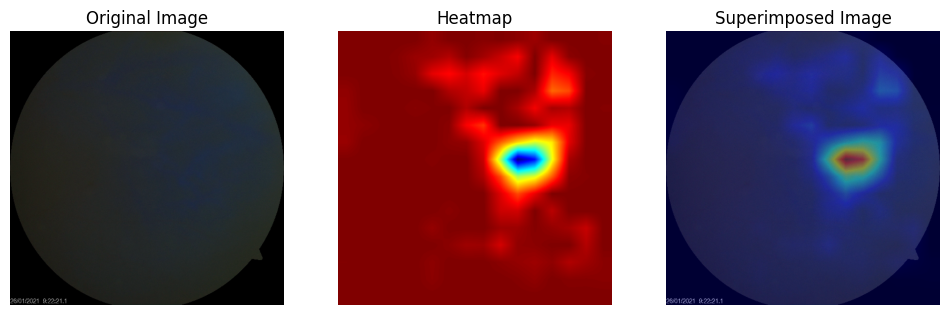

Context Gating Attention
(1, 7)
Very Severe NPDR


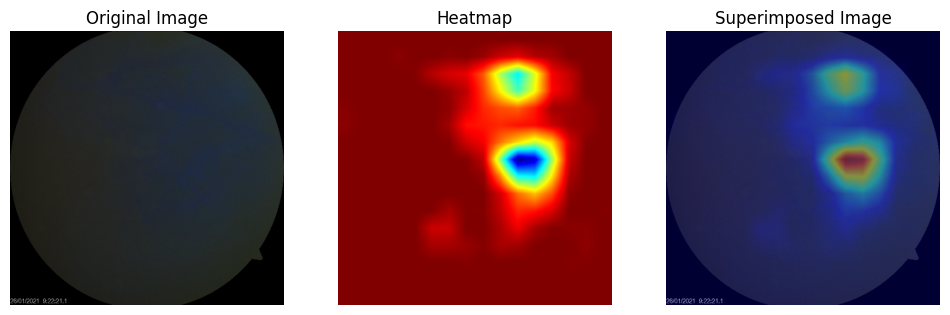

Sample:  3
Actual Label:  Severe NPDR
Global Context Attention
(1, 7)
Severe NPDR


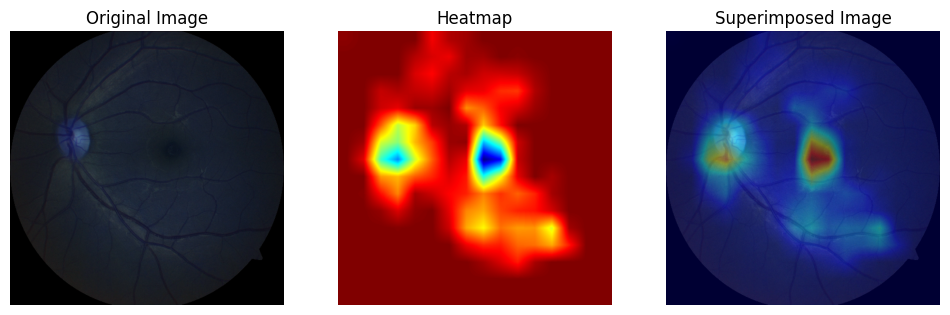

Context Gating Attention
(1, 7)
Severe NPDR


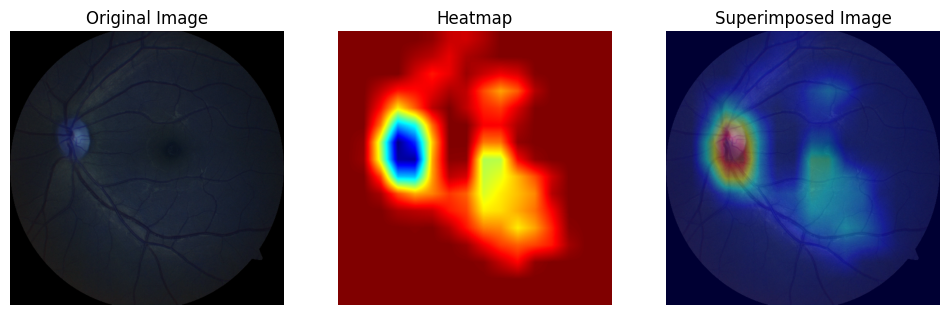

Sample:  4
Actual Label:  Advanced PDR
Global Context Attention
(1, 7)
Advanced PDR


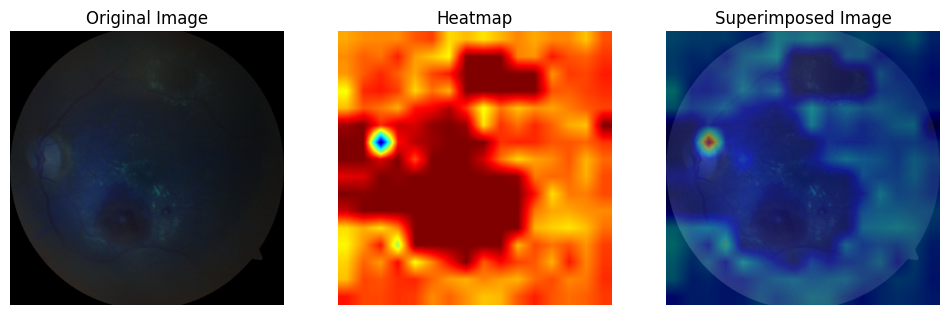

Context Gating Attention
(1, 7)
Advanced PDR


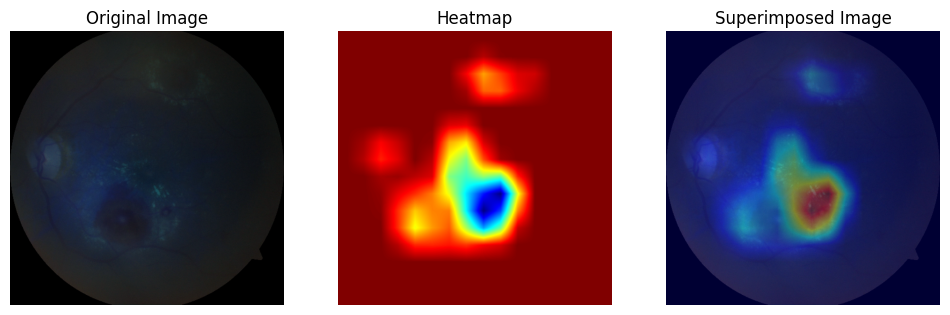

Sample:  5
Actual Label:  Advanced PDR
Global Context Attention
(1, 7)
Advanced PDR


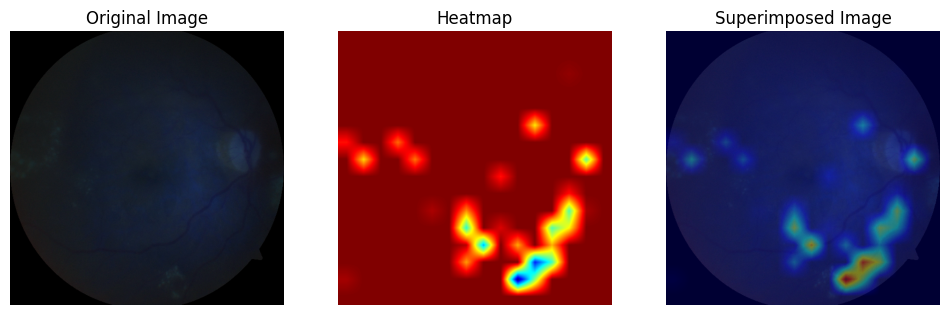

Context Gating Attention
(1, 7)
Advanced PDR


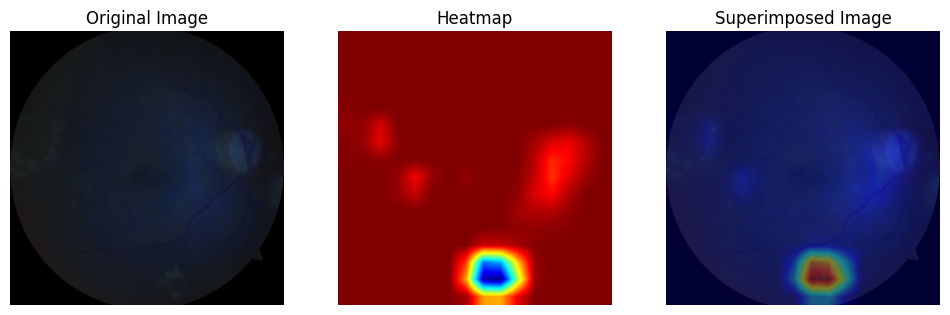

Sample:  6
Actual Label:  Moderate NPDR
Global Context Attention
(1, 7)
Moderate NPDR


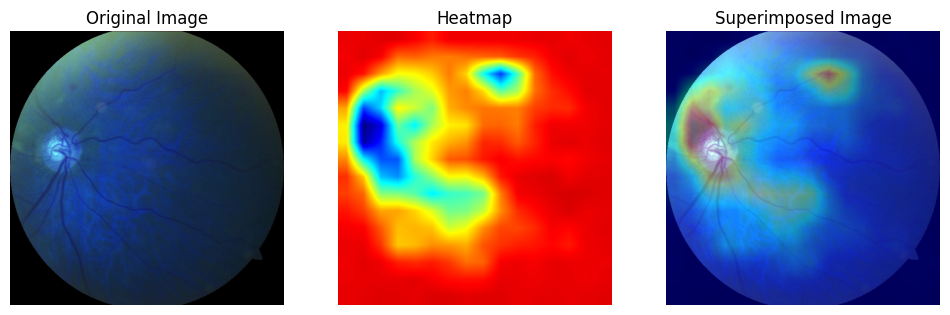

Context Gating Attention
(1, 7)
Moderate NPDR


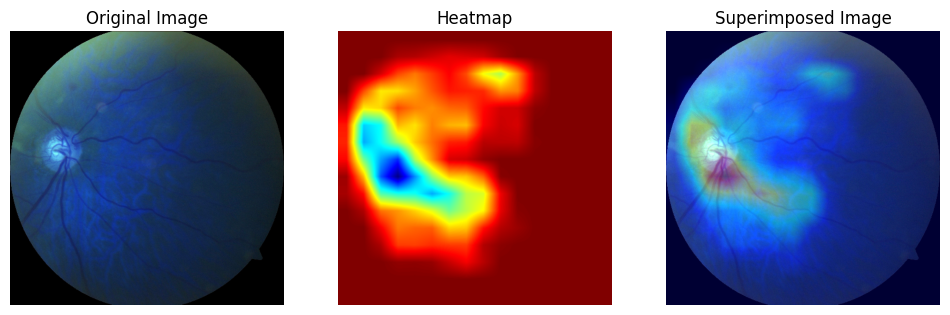

Sample:  7
Actual Label:  Severe NPDR
Global Context Attention
(1, 7)
Severe NPDR


In [13]:
import random
random.seed(360)

best_weights = '/Users/nagurshareefshaik/Desktop/MSCS/MyResearch/Zenodo DR 7/CGNetv2/cgnetv2.weights.best.hdf5'
model.load_weights(best_weights)

gcatt_layer_name = 'add'
cgatt_layer_name = 'attention_gate'

num_imgs = 25
img_indxs = random.sample(range(0, X_test.shape[0]), num_imgs)

labels = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Very Severe NPDR', 'PDR', 'Advanced PDR']
counter = 1
for indx in img_indxs:
    img = X_test[indx]
    print("Sample: ", counter)
    print("Actual Label: ", labels[np.argmax(y_test[indx])])
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1)[0]

    # %% result of grad cam++

    # Global Context Att
    print("Global Context Attention")
    heatmap_plus = grad_cam_plus(model, img, gcatt_layer_name, label_name = labels, category_id = pred)
    show_GradCAM(img, heatmap_plus)

    # Context Gating Att
    print("Context Gating Attention")
    heatmap_plus = grad_cam_plus(model, img, cgatt_layer_name, label_name = labels, category_id = pred)
    show_GradCAM(img, heatmap_plus)
    counter+=1

